In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

dataset, info = tfds.load("fashion_mnist", split="train", with_info=True)

def convert(row):
    image = tf.image.convert_image_dtype(row["image"], tf.float32)
    label = tf.cast(row["label"], tf.float32)
    return image, label

batch_size = 32
dataset = dataset.map(convert).batch(batch_size).prefetch(1)


In [2]:
#생성기 정의
def get_generator(latent_dimension):
    #조건 서브 네트워크 : 조건을 히든 표현으로 인코딩
    condition = tf.keras.layers.Input((1,))
    net = tf.keras.layers.Dense(32, activation=tf.nn.elu)(condition)
    net = tf.keras.layers.Dense(64, activation=tf.nn.elu)(net)
    #히든 조건 표현을 노이즈와 업샘플에 연결
    noise = tf.keras.layers.Input(latent_dimension)
    inputs = tf.keras.layers.Concatenate()([noise, net])
    # Convert inputs from (batch_size, latent_dimension +1)
    #(batch)size, latent_dimension + 1)인 inputs를
    #컨볼류션을 사용할 수 있는 4차원 텐서로 변경
    inputs = tf.keras.layers.Reshape((1,1, inputs.shape[-1]))(inputs)
    depth = 128
    kernel_size = 5
    net = tf.keras.layers.Conv2DTranspose(
        depth, kernel_size,
        padding="valid",
        strides=1,
        activation=tf.nn.relu)(inputs)# 5X5
    net = tf.keras.layers.Conv2DTranspose(
        depth//2, kernel_size,
        padding="valid",
        strides=2,
        activation=tf.nn.relu)(net) # 13X13
    net = tf.keras.layers.Conv2DTranspose(
        depth//4, kernel_size,
        padding="valid",
        strides=2,
        activation=tf.nn.relu,
        use_bias = False )(net) #29X29
    #28X28X1 출력을 얻기 위해 2x2 커널과의 표준 컨볼류션
    #이미지가 [0,1] 범위에 있기 때문에 출력은 sigmoid를 사용한다.

    net = tf.keras.layers.Conv2D(
        1,2,
        padding = "valid",
        strides = 1,
        activation = tf.nn.sigmoid,
        use_bias= False)(net)

    model = tf.keras.Model(inputs=[noise, condition], outputs=net)
    return model


In [3]:
#판별기 정의
def get_discriminator():
    #인코더 서브네트워크: 피처 벡터를 얻는 피처 추출기
    image = tf.keras.layers.Input((28,28,1))
    depth = 32
    kernel_size = 3
    net = tf.keras.layers.Conv2D(
        depth, kernel_size,
        padding="same",
        strides = 2,
        activation=tf.nn.relu)(image) #14x14x32
    net = tf.keras.layers.Conv2D(
        depth*2, kernel_size,
        padding="same",
        strides = 2,
        activation=tf.nn.relu)(net) #7x7x64
    net = tf.keras.layers.Conv2D(
        depth*3, kernel_size,
        padding="same",
        strides = 2,
        activation=tf.nn.relu)(net) #4x4x96
    feature_vector = tf.keras.layers.Flatten()(net) #4*4*96
    #조건에 관한 히든 표현 만들기
    condition = tf.keras.layers.Input((1,))
    hidden = tf.keras.layers.Dense(32, activation=tf.nn.elu)(condition)
    hidden = tf.keras.layers.Dense(64, activation=tf.nn.elu)(hidden)
    # 피처 벡터와 히든 레이블 표현 연결
    out = tf.keras.layers.Concatenate()([feature_vector, hidden])
    # 단일 선형 뉴런으로 이뤄진 최종 분류 레이어 추가
    out = tf.keras.layers.Dense(128, activation=tf.nn.relu)(out)
    out = tf.keras.layers.Dense(1)(out)
    model = tf.keras.Model(inputs = [image, condition], outputs = out)
    return model

In [4]:
#적대적 훈련 과정
bce = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def d_loss(d_real, d_fake):
    '''판별기 손실함수'''
    return bce(tf.ones_like(d_real), d_real) + bce(tf.zeros_like(d_fake), d_fake)
    
def g_loss(generated_output):
    '''생성기 손실함수'''
    return bce(tf.ones_like(generated_output), generated_output)




In [ ]:

latent_dimension = 100
G = get_generator(latent_dimension)
D = get_discriminator()

def train():
    #옵티마이저 및 학습 연산을 정의한다.
    optimizer = tf.keras.optimizers.Adam(1e-5)

    @tf.function
    def train_step(image, label):
        with tf.GradientTape(persistent=True) as tape:
            noise_vector = tf.random.normal(
                mean=0, stddev=1,
                shape=(image.shape[0], latent_dimension))
            #생성기에서 샘풀링
            fake_data = G([noise_vector, label])
            # D 손실 계산
            d_fake_data = D([fake_data, label])
            d_real_data = D([image, label])
            d_loss_value = d_loss(d_real_data, d_fake_data)
            #G 손실 계산
            g_loss_value = g_loss(d_fake_data)
            #이제 손실을 계산했으므로 그래디언트를 계산하고
            #네트워크를 최적화 할 수 있다.
        d_gradients = tape.gradient(d_loss_value, D.trainable_variables)
        g_gradients = tape.gradient(g_loss_value, G.trainable_variables)
        # 테이프를 영구로 정의했기 때문에 테이프 삭제
        del tape

        optimizer.apply_gradients(zip(d_gradients, D.trainable_variables))
        optimizer.apply_gradients(zip(g_gradients, G.trainable_variables))
        return g_loss_value, d_loss_value, fake_data[0], label[0]

    epochs = 10
    for epoch in range(epochs):
        for image, label in dataset:
            g_loss_value, d_loss_value, generated, condition = train_step(image, label)

        print("epoch", epoch, "complete")
        print("loss:", g_loss_value, "d_loss:", d_loss_value)
        print("condition", info.features["label"].int2str(
            tf.squeeze(tf.cast(condition, tf.int32)).numpy()))
        plt.imshow(tf.squeeze(generated).numpy(), cmap="gray")
        plt.show()



epoch 0 complete
loss: tf.Tensor(2.4797385, shape=(), dtype=float32) d_loss: tf.Tensor(0.48697186, shape=(), dtype=float32)
condition Dress


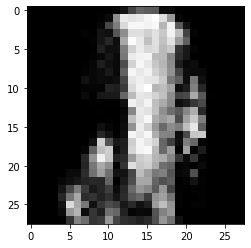

epoch 1 complete
loss: tf.Tensor(1.5852678, shape=(), dtype=float32) d_loss: tf.Tensor(0.40996987, shape=(), dtype=float32)
condition Dress


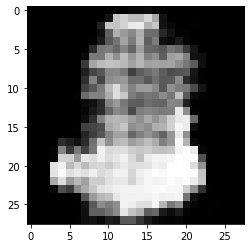

epoch 2 complete
loss: tf.Tensor(1.2290068, shape=(), dtype=float32) d_loss: tf.Tensor(0.5917632, shape=(), dtype=float32)
condition Dress


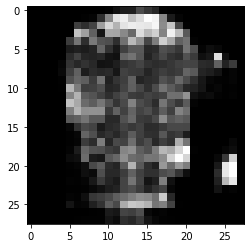

epoch 3 complete
loss: tf.Tensor(1.672901, shape=(), dtype=float32) d_loss: tf.Tensor(0.49679625, shape=(), dtype=float32)
condition Dress


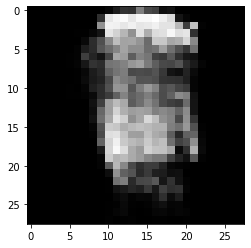

epoch 4 complete
loss: tf.Tensor(1.6632812, shape=(), dtype=float32) d_loss: tf.Tensor(0.49645174, shape=(), dtype=float32)
condition Dress


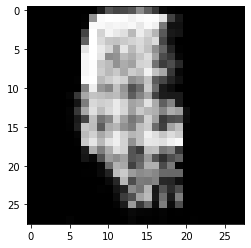

epoch 5 complete
loss: tf.Tensor(1.8670795, shape=(), dtype=float32) d_loss: tf.Tensor(0.53422517, shape=(), dtype=float32)
condition Dress


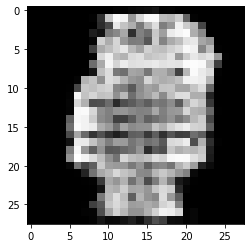

epoch 6 complete
loss: tf.Tensor(1.610527, shape=(), dtype=float32) d_loss: tf.Tensor(0.7886286, shape=(), dtype=float32)
condition Dress


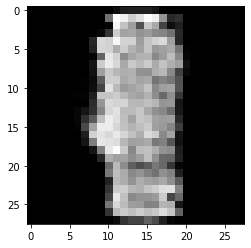

epoch 7 complete
loss: tf.Tensor(1.6873208, shape=(), dtype=float32) d_loss: tf.Tensor(0.5399401, shape=(), dtype=float32)
condition Dress


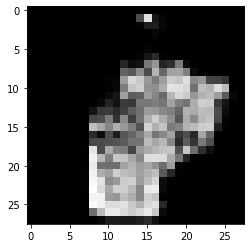

epoch 8 complete
loss: tf.Tensor(2.0759351, shape=(), dtype=float32) d_loss: tf.Tensor(0.3661743, shape=(), dtype=float32)
condition Dress


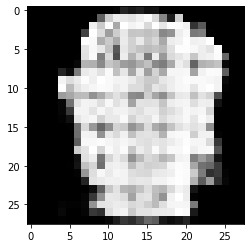

epoch 9 complete
loss: tf.Tensor(1.5881915, shape=(), dtype=float32) d_loss: tf.Tensor(0.50432825, shape=(), dtype=float32)
condition Dress


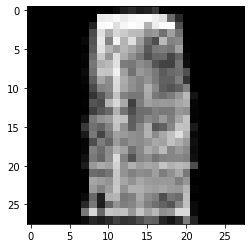

In [6]:
train()